In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# датасет с примером соответствий 

example_df = pd.read_csv(r'C:\Users\artyo\OneDrive\Рабочий стол\1f\02_etalon.csv', sep = ';')

In [3]:
# датасет с инфо о регистрациях на базовых станциях 

dataset = pd.read_csv(r'C:\Users\artyo\OneDrive\Рабочий стол\1f\01_data.csv', sep = ';')

In [4]:
# Проверим dataset на незаполненные значения

dataset.isnull().sum()

# таковые отсутствуют

lac         0
cid         0
ts          0
fulldate    0
hash_id     0
dtype: int64

In [5]:
# Проверим example_df на незаполненные значения

example_df.isnull().sum()

id1    0
id2    0
dtype: int64

In [6]:
# Проверим example_df на дубли 

example_df['id1'].duplicated().value_counts()

False    491
Name: id1, dtype: int64

In [7]:
# Проверим example_df на дубли 

example_df['id2'].duplicated().value_counts()

False    491
Name: id2, dtype: int64

In [8]:
# Проверим example_df на дубли 

example_df.duplicated().value_counts()

# таковых нет

False    491
dtype: int64

In [9]:
# Добавим в dataset имеющиеся соответствия
# Первый left join 

df = pd.merge(dataset, 
              example_df.rename( columns = {'id1':'hash_id','id2': '1st_id'}), 
              on='hash_id', 
              how = 'left')

In [10]:
# Добавим в dataset имеющиеся соответствия
# Второй left join 

df = pd.merge(df, 
              example_df.rename( columns = {'id2':'hash_id','id1': '2nd_id'}), 
              on='hash_id', 
              how = 'left')

In [11]:
# комбинация двух полей после left join-ов

df['related_id'] = df['1st_id'].combine_first(df['2nd_id'])

In [12]:
# Дроп избыточных полей

df.drop(columns = ['1st_id', '2nd_id'],
        axis = 1,
        inplace = True)

In [13]:
# Проверим, имеются ли записи по различным годам

pd.DatetimeIndex(df['fulldate']).year.value_counts()

# не имеются

2018    9153692
Name: fulldate, dtype: int64

In [14]:
# Проверим, имеются ли записи по различным месяцам

pd.DatetimeIndex(df['fulldate']).month.value_counts()

# не имеются

9    9153692
Name: fulldate, dtype: int64

In [15]:
# Из всей даты оставим только день 

df['day'] = pd.DatetimeIndex(df['fulldate']).day
df.drop(columns = 'fulldate',
        axis = 1,
        inplace = True)

In [16]:
# Приведём секунды к int для более простого восприятия

df['ts'] = df['ts'].astype(int)

In [17]:
df.sample(10)

,lac,cid,ts,hash_id,related_id,day
2319340,9705,197985542,1536515708,1219865,NaN,9
317864,9739,197971458,1536504236,1885726,2176298.0,9
4525873,7752,6313,1538148791,2756372,1963733.0,28
8001326,7752,764,1537425762,2585414,NaN,20
6638845,9716,15703044,1537114735,2897196,NaN,16
4043894,5028,129308929,1536849571,1898158,NaN,13
3005483,9711,197800736,1536412865,1561119,NaN,8
61686,9716,31422,1535863016,1213812,2785640.0,2
4906667,9017,231617283,1538260140,2948417,1706783.0,29
5809789,9701,254263301,1538060900,2977512,NaN,27


In [18]:
# Выберем данные с заполненным related_id
# Это будет рабочим сетом

rel_df = df.loc[df['related_id'].isna() == False]

In [19]:
# Выберем данные с незаполненным related_id
# Для него нужно найти соответствия

not_rel_df = df.loc[df['related_id'].isna() == True]

In [20]:
# разделим данные на две части месяца

first_rel_df = rel_df.loc[rel_df['day'] < 15]
second_rel_df  = rel_df.loc[rel_df['day'] > 15]

### Первый показатель для поиска соответствий: 
Схожесть количества регистраций клиента в паре *lac/cid* в первой и второй половинах месяца.

In [21]:
# Для каждого hash_id первой половины посчитаем,
# сколько раз hash_id регистрировался в каждой паре lac/cid

f1_prep = first_rel_df.groupby(['hash_id',
                               'lac',
                               'cid'])['day'].count().reset_index(name='counts')

In [22]:
# Для каждого hash_id второй половины посчитаем,
# сколько раз hash_id регистрировался в каждой паре lac/cid

s1_prep = second_rel_df.groupby(['hash_id',
                                'lac',
                                'cid'])['day'].count().reset_index(name='counts')

In [23]:
# Будем искать соответствие hash_id первой и второй половины на основании пар lac/cid и количества регистраций в них
# соединим два подготовленных в предыдущих шагах датафрейма

f_df = pd.merge(f1_prep, 
                s1_prep, 
                on= ['lac','cid'], 
                how = 'inner')

In [24]:
f_df.head()

,hash_id_x,lac,cid,counts_x,hash_id_y,counts_y
0,1001168,5007,7830,1,2308273,2
1,1001168,5007,14055,1,2210701,1
2,1001168,5007,14055,1,2444978,2
3,1001168,5007,14055,1,2565113,1
4,1157689,5007,14055,1,2210701,1


### Второй показатель для поиска соответствий: 
Схожесть количества секунд, которые клиент провёл в паре *lac/cid* в первой и второй половинах месяца.
Под количеством проведенных в паре *lac/cid* секунд подразумевает разность между ts_2 и ts_1, где: 
 * ts_1 - UNIX-время, в которое клиент был зарегистрирова в паре *lac/cid* (обозначим пару A)
 * ts_2 - UNIX-время, в которое  клиент был зарегистрирова в следующей паре *lac/cid*, отличной от A 

т.е. это разность UNIX-времени, для двух последовательных различных пар *lac/cid* в случае сортировки в порядке возрастания ts

In [25]:
# Отсортируем датафрейм первой половины месяца с имеющимися соответствиями идентификаторов 
# в порядке возрастания hash_id, day, ts

ftdf = first_rel_df.sort_values(by=['hash_id','day','ts'])

In [26]:
# Подтянем ts следующей записи для каждого hash_id и вычтем из него ts текущей
# В случае, если у следующей записи тот же ts, получим 0 

ftdf['lead'] = ftdf.groupby(['hash_id'])['ts'].shift(-1) - ftdf['ts']

In [27]:
# Если же запись последняя, проставим 0 

ftdf['lead'].fillna(0, inplace = True)

In [28]:
# Просуммируем время пребывания клиента на каждой паре lac/cid

ftdf = ftdf.groupby(['hash_id','lac','cid'])['lead'].sum().reset_index(name = 'sec')

In [29]:
# Действия выше производились для первой половины месяца.
# Теперь повторим то же самое для второй половины.

stdf = second_rel_df.sort_values(by=['hash_id','day','ts'])
stdf['lead'] = stdf.groupby(['hash_id'])['ts'].shift(-1) - stdf['ts']
stdf['lead'].fillna(0, inplace = True)
stdf = stdf.groupby(['hash_id','lac','cid'])['lead'].sum().reset_index(name = 'sec')

In [30]:
# Будем искать соответствие hash_id первой и второй половины на основании пар lac/cid и количества проведенных секунд в них
# соединим два подготовленных в предыдущих шагах датафрейма

s_df = pd.merge(ftdf, 
                stdf, 
                on= ['lac','cid'], 
                how = 'inner')

In [31]:
# Первый датафрейм содержит количество регистраций клиентов в парах lac/cid 
# Второй датафрейм содержит число секунд, проведенных клиентом в парах lac/cid 

f_df.shape, s_df.shape

((5222092, 6), (5222092, 6))

In [32]:
f_df.head()

,hash_id_x,lac,cid,counts_x,hash_id_y,counts_y
0,1001168,5007,7830,1,2308273,2
1,1001168,5007,14055,1,2210701,1
2,1001168,5007,14055,1,2444978,2
3,1001168,5007,14055,1,2565113,1
4,1157689,5007,14055,1,2210701,1


In [33]:
s_df.head()

,hash_id_x,lac,cid,sec_x,hash_id_y,sec_y
0,1001168,5007,7830,30.0,2308273,45.0
1,1001168,5007,14055,312.0,2210701,17.0
2,1001168,5007,14055,312.0,2444978,147.0
3,1001168,5007,14055,312.0,2565113,8.0
4,1157689,5007,14055,22.0,2210701,17.0


In [34]:
# Сформируем третий, который будет содержать оба показателя, на основании которых будем искать соответствие

df = pd.merge(f_df, 
              s_df, 
              on= ['lac','cid', 'hash_id_x', 'hash_id_y'], 
              how = 'inner')

In [35]:
df.sort_values(by=['hash_id_x','counts_x','counts_y'], ascending = False).head()

,hash_id_x,lac,cid,counts_x,hash_id_y,counts_y,sec_x,sec_y
170373,1998843,7716,3668,61,2518576,75,267878.0,413820.0
170386,1998843,7716,3668,61,2914090,42,267878.0,62215.0
170375,1998843,7716,3668,61,2549114,34,267878.0,12623.0
170357,1998843,7716,3668,61,2062742,32,267878.0,9375.0
170377,1998843,7716,3668,61,2566308,28,267878.0,83607.0


В получившемся сете находятся все комбинации пар *hash_id* из первой и второй половины месяца, у которых есть пересечения по парам *lac/cid*
т.е. те *hash_id*, которые регистрировались в одних и тех же *lac/cid*
 * hash_id_x  - id клиента из первой половины месяца
 * hash_id_y - id клиента из второй половины месяца
 * counts_x - количество регистраций клиента в паре lac/cid в первой половине месяца 
 * counts_y - количество регистраций клиента в паре lac/cid во второй половине месяца
 * sec_x - количество секунд, проведенных клиентом в паре lac/cid в первой половине месяца
 * sec_y - количество секунд, проведенных клиентом в паре lac/cid во второй половине месяца

 
 
Теперь задачей является определение таких пар *hash_id* из первой и второй половины, у которых **наиболее близки по значению**  *counts_x * и *counts_y*, а также *sec_x* и *sec_y*

In [36]:
# Зададим абсолютную разность в проведенных секундах в lac/cid первой и второй половинах месяца

df['dif_s'] = abs(df['sec_x'] - df['sec_y'])

In [37]:
# Зададим абсолютную разность в количестве регистраций в lac/cid первой и второй половинах месяца

df['dif_c'] = abs(df['counts_x'] - df['counts_y'])

In [38]:
# Нормируем абсолютную ошибку (будем называть разность так) в проведенных секундах в lac/cid первой и второй половинах месяца

df['norm_dif_c'] = (df['dif_c'] - df['dif_c'].min())/(df['dif_c'].max() - df['dif_c'].min())

In [39]:
# Нормируем абсолютную ошибку в количестве регистраций в lac/cid первой и второй половинах месяца

df['norm_dif_s'] = (df['dif_s'] - df['dif_s'].min())/(df['dif_s'].max() - df['dif_s'].min())

In [40]:
df.head()

,hash_id_x,lac,cid,counts_x,hash_id_y,counts_y,sec_x,sec_y,dif_s,dif_c,norm_dif_c,norm_dif_s
0,1001168,5007,7830,1,2308273,2,30.0,45.0,15.0,1,0.000248,0.000009
1,1001168,5007,14055,1,2210701,1,312.0,17.0,295.0,0,0.000000,0.000181
2,1001168,5007,14055,1,2444978,2,312.0,147.0,165.0,1,0.000248,0.000101
3,1001168,5007,14055,1,2565113,1,312.0,8.0,304.0,0,0.000000,0.000187
4,1157689,5007,14055,1,2210701,1,22.0,17.0,5.0,0,0.000000,0.000003


In [41]:
# Под итоговой ошибкой будем считать сумму двух подготовленных ошибок 

df['dif'] = df['norm_dif_c'] + df['norm_dif_s']

In [42]:
# Оставим те записи, у которых итоговая ошибка будет минимальной для hash_id из первой половины месяца 

df = df.loc[df['dif'] == df.groupby(['hash_id_x',
                                     'lac',
                                     'cid'])['dif'].transform('min')]

In [43]:
# Получена табличка, которая хранит в себе уникальные lac/cid, в которых клиент регистрировался
# как в первой, так и во второй половине месяца

# Причем выбраны те записи, у которых абсолютная ошибка наименьшая
# т.е. наиболее каждой lac/cid выставлены наиболее похожие комбинации hash_id_x и hash_id_y

df.sort_values(by=['hash_id_x'], ascending = False)[['hash_id_x','lac','cid','hash_id_y','dif']].head(17)

# Осталось посчитать для каждого hash_id_x наиболее часто встречающийся hash_id_y 

,hash_id_x,lac,cid,hash_id_y,dif
5222091,1998843,7785,38649,2518576,0.000001
2579022,1998843,7755,44712,2756372,0.000525
5180433,1998843,7755,2981,2019342,0.000066
5183339,1998843,7729,13350,2518576,0.000296
5183356,1998843,7729,36811,2476587,0.000006
5184666,1998843,7755,44698,2295202,0.000883
5198993,1998843,7700,1335,2806696,0.000009
2579032,1998843,7755,44713,2714643,0.000145
2578697,1998843,7755,2997,2715995,0.000024
5173981,1998843,7785,28364,2458905,0.000005


In [44]:
# Считаем количество раз, когда hash_id_y получал наименьшую ошибку для hash_id_x

df = df.groupby(['hash_id_x',
                 'hash_id_y']).size().reset_index(name = 'counts')

In [45]:
df.head(17).sort_values(by=['hash_id_x', 'counts'], ascending = False)

,hash_id_x,hash_id_y,counts
3,1001168,2038453,14
0,1001168,2007517,4
14,1001168,2224609,4
1,1001168,2015067,2
16,1001168,2235737,2
2,1001168,2030532,1
4,1001168,2062791,1
5,1001168,2119842,1
6,1001168,2124865,1
7,1001168,2135070,1


In [46]:
# Оставляем записи с наиболее часто встречающимися hash_id_y для hash_id_x

df = df.loc[df.groupby(['hash_id_x'])['counts'].idxmax()].sort_values(by=['counts'],ascending  = False)

In [47]:
df.head(17)

,hash_id_x,hash_id_y,counts
4714,1070773,2797567,228
35830,1522878,2586410,209
40382,1590607,2870254,206
19373,1280078,2900614,193
58094,1834586,2514357,184
30582,1459012,2199609,148
44843,1652233,2992230,145
44273,1640319,2983716,137
19818,1296482,2489230,136
23487,1365250,2054920,128


In [48]:
# Переименовываем атрибут для соединения с example_df

df.rename(columns={"hash_id_x": "id1"}, inplace = True)

In [49]:
# Cоединяем с example_df для оценки результата

res_df = pd.merge(example_df, 
                 df, 
                 on= ['id1'], 
                 how = 'left')

In [50]:
# Проставляем флаг верного попадания

res_df['err'] = (res_df['id2'] - res_df['hash_id_y']).apply(lambda x: x if x == 0 else 1)

In [51]:
# Считаем долю верных попаданий 
res_df.loc[res_df['err'] == 0].shape[0]/res_df.shape[0]

0.835030549898167

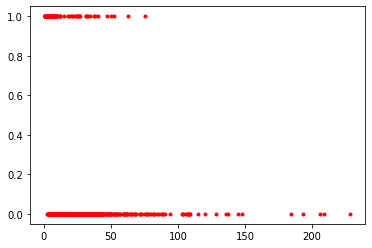

In [52]:
# распределение ошибок в зависимости от частоты пересечений hash_id_x и hash_id_y 
# т.е. пропорциональность ошибки и числа записей для клиента в начале и конце месяца

plt.plot(res_df['counts'],res_df['err'], '.', color='red');

In [56]:
# количество присвоений hash_id_y 
# > 1 - дубль

res_df['hash_id_y'].value_counts().value_counts()

1    361
2     40
3      9
4      3
6      1
5      1
Name: hash_id_y, dtype: int64

###  Формирование соответствий на неразмеченном датасете

In [59]:
# разделим данные на две части месяца
first_not_rel_df = not_rel_df.loc[not_rel_df['day'] < 15]
second_not_rel_df  = not_rel_df.loc[not_rel_df['day'] > 15]


# Для каждого hash_id первой половины посчитаем,
# сколько раз hash_id регистрировался в каждой паре lac/cid
f1_prep = first_not_rel_df.groupby(['hash_id',
                                    'lac',
                                    'cid'])['day'].count().reset_index(name='counts')


# Для каждого hash_id второй половины посчитаем,
# сколько раз hash_id регистрировался в каждой паре lac/cid
s1_prep = second_not_rel_df.groupby(['hash_id',
                                     'lac',
                                     'cid'])['day'].count().reset_index(name='counts')


# Будем искать соответствие hash_id первой и второй половины на основании пар lac/cid и количества регистраций в них
# соединим два подготовленных в предыдущих шагах датафрейма
f_df = pd.merge(f1_prep, 
                s1_prep, 
                on= ['lac','cid'], 
                how = 'inner')



# Отсортируем датафрейм первой половины месяца с имеющимися соответствиями идентификаторов 
# в порядке возрастания hash_id, day, ts
ftdf = first_not_rel_df.sort_values(by=['hash_id','day','ts'])


# Подтянем ts следующей записи для каждого hash_id и вычтем из него ts текущей
# В случае, если у следующей записи тот же ts, получим 0 
ftdf['lead'] = ftdf.groupby(['hash_id'])['ts'].shift(-1) - ftdf['ts']


# Подтянем ts следующей записи для каждого hash_id и вычтем из него ts текущей
# В случае, если у следующей записи тот же ts, получим 0 
ftdf['lead'] = ftdf.groupby(['hash_id'])['ts'].shift(-1) - ftdf['ts']


# Если же запись последняя, проставим 0 
ftdf['lead'].fillna(0, inplace = True)


# Просуммируем время пребывания клиента на каждой паре lac/cid
ftdf = ftdf.groupby(['hash_id','lac','cid'])['lead'].sum().reset_index(name = 'sec')


# Действия выше производились для первой половины месяца.
# Теперь повторим то же самое для второй половины.
stdf = second_not_rel_df.sort_values(by=['hash_id','day','ts'])
stdf['lead'] = stdf.groupby(['hash_id'])['ts'].shift(-1) - stdf['ts']
stdf['lead'].fillna(0, inplace = True)
stdf = stdf.groupby(['hash_id','lac','cid'])['lead'].sum().reset_index(name = 'sec')


# Будем искать соответствие hash_id первой и второй половины на основании пар lac/cid и количества проведенных секунд в них
# соединим два подготовленных в предыдущих шагах датафрейма
s_df = pd.merge(ftdf, 
                stdf, 
                on= ['lac','cid'], 
                how = 'inner')


# Первый датафрейм содержит количество регистраций клиентов в парах lac/cid 
# Второй датафрейм содержит число секунд, проведенных клиентом в парах lac/cid 
# Сформируем третий, который будет содержать оба показателя, на основании которых будем искать соответствие
df = pd.merge(f_df, 
              s_df, 
              on= ['lac','cid', 'hash_id_x', 'hash_id_y'], 
              how = 'inner')


# Зададим абсолютную разность в проведенных секундах в lac/cid первой и второй половинах месяца
df['dif_s'] = abs(df['sec_x'] - df['sec_y'])


# Зададим абсолютную разность в количестве регистраций в lac/cid первой и второй половинах месяца
df['dif_c'] = abs(df['counts_x'] - df['counts_y'])


# Нормируем абсолютную ошибку (будем называть разность так) в проведенных секундах в lac/cid первой и второй половинах месяца
df['norm_dif_c'] = (df['dif_c'] - df['dif_c'].min())/(df['dif_c'].max() - df['dif_c'].min())


# Нормируем абсолютную ошибку в количестве регистраций в lac/cid первой и второй половинах месяца
df['norm_dif_s'] = (df['dif_s'] - df['dif_s'].min())/(df['dif_s'].max() - df['dif_s'].min())


# Под итоговой ошибкой будем считать сумму двух подготовленных ошибок 
df['dif'] = df['norm_dif_c'] + df['norm_dif_s']


# Оставим те записи, у которых итоговая ошибка будет минимальной для hash_id из первой половины месяца 
df = df.loc[df['dif'] == df.groupby(['hash_id_x',
                                     'lac',
                                     'cid'])['dif'].transform('min')].sort_values(by=['hash_id_x'], ascending = False)


# Считаем количество раз, когда hash_id_y получал наименьшую ошибку для hash_id_x
df = df.groupby(['hash_id_x',
                 'hash_id_y']).size().reset_index(name = 'counts')


# Оставляем записи с наиболее часто встречающимися hash_id_y для hash_id_x
df = df.loc[df.groupby(['hash_id_x'])['counts'].idxmax()].sort_values(by=['counts'],ascending  = False)

In [60]:
df.rename( columns = {'hash_id_x':'hash_id','hash_id_y': 'related_id'}, inplace = True),
df.head()

,hash_id,related_id,counts
325340,1704031,2295025,238
449631,1969808,2804394,210
59679,1127318,2330455,208
292988,1638622,2755019,168
73150,1151815,2521795,148


In [61]:
# выберем уникальные hash_id, у которых нет изначального соответствия

res_df = pd.DataFrame(first_not_rel_df['hash_id'].unique(), columns = ['hash_id']) 

In [62]:
# Подтянем к ним полученные соответствия 

res_df = pd.merge(res_df, 
                  df,
                  on='hash_id', 
                  how = 'left')

In [63]:
res_df.rename( columns = {'hash_id':'id1','related_id': 'id2'}, inplace = True)
res_df = res_df[['id1', 'id2']]

# Увы, есть один неопределившийся hash_id из второй половины
res_df['id2'] = res_df['id2'].fillna(-1).astype(int)

In [64]:
res_df['id2'].value_counts().value_counts()

1     1043
2      217
3       53
4       18
5        3
12       1
9        1
7        1
6        1
Name: id2, dtype: int64

In [65]:
res_df.shape

(1757, 2)

In [60]:
res_df.to_csv(r'C:\Users\artyo\OneDrive\Рабочий стол\1f\03_result.csv', sep = ';')